# Recurrent Neural Network (LSTM)
We use a Long Short Term Memory (LSTM) network to make predictions.
Resources:
https://towardsdatascience.com/using-lstms-to-forecast-time-series-4ab688386b1f

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dropout, LSTM, Dense, Activation
import time
import csv
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


## 1) Pure sin wave

Our goal is to predict a time series using an LSTM. We will start, as a proof of concept, with a perfect sine wave. If the network is functioning, it should be able to predict this with nearly 100% accuracy.

(0, 0.1)

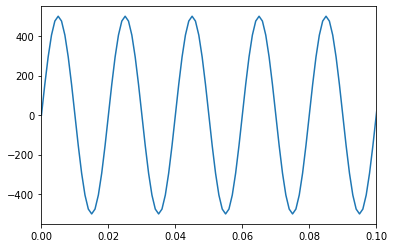

In [2]:
%matplotlib inline
df = pd.read_csv('./data/50Hzsinwave.csv',header=None)
dataset = df.values

dataset[:,1] = dataset[:,1]*500
plt.plot(dataset[:,0],dataset[:,1])
plt.xlim(0,0.1)

Use the series_to_supervised function to transform the time series into a supervised learning problem.

In [3]:
from utils import series_to_supervised

num_lookback = 500
num_predict = 100
# n_in is the number of samples for "input" and n_out is the number for "output", or prediction
supervised_dataset = series_to_supervised(dataset[:,1:2],n_in=num_lookback,n_out=num_predict)
sup_ds = supervised_dataset.values

The data will typically need to be scaled. Here, we perform mean normalization to scale the data.

In [4]:
row_mean = sup_ds.mean(axis=1,keepdims=True)
row_max = sup_ds.max(axis=1,keepdims=True)
row_min = sup_ds.min(axis=1,keepdims=True)

scl_sup_ds = (sup_ds-row_mean)/(row_max-row_min)

Now we just need to split the scaled dataset into training and testing.

In [5]:
N_train = int(0.8*np.size(scl_sup_ds,0))

scaled_train = scl_sup_ds[0:N_train,:]
scaled_test = scl_sup_ds[N_train:,:]

Now we will define the model.

In [6]:
def fit_lstm(train, n_lag, n_batch, nb_epoch, n_neurons):
    # reshape training into [samples, timesteps, features]
    X, y = train[:, 0:-n_lag], train[:, -n_lag:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    # define parameters
    verbose, epochs, batch_size = 1, nb_epoch, n_batch
    n_timesteps, n_features, n_outputs = X.shape[1], X.shape[2], y.shape[1]
    # design network
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model
    
model_lstm = fit_lstm(scaled_train, num_predict, 10, 5, 300)
model_lstm.summary()

Epoch 1/5
320/320 [==============================] - 3s 9ms/step - loss: 0.0513
Epoch 2/5
320/320 [==============================] - 1s 3ms/step - loss: 0.0023
Epoch 3/5
320/320 [==============================] - 1s 2ms/step - loss: 5.0126e-04
Epoch 4/5
320/320 [==============================] - 1s 3ms/step - loss: 2.6486e-04
Epoch 5/5
320/320 [==============================] - 1s 3ms/step - loss: 2.0796e-04
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 200)               560800    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
Total params: 591,000
Trainable params: 591,000
Non-trainable params: 0
________________________________

In [7]:
# Make one forecast
def forecast_lstm(model, X, n_batch):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, len(X))
    # make forecast
    forecast = model.predict(X, batch_size=n_batch)
    # convert to array
    return forecast

def make_forecasts(model, n_batch, test, n_lag):
    forecasts = np.zeros((test.shape[0],n_lag))
    for i in range(test.shape[0]):
        X, y = test[i, 0:-n_lag], test[i, -n_lag:]
        # make forecast
        forecasts[i,:] = forecast_lstm(model, X, n_batch)
    return forecasts

scaled_forecasts = make_forecasts(model_lstm, 1, scaled_test, num_predict)

(81, 100) (81, 600)


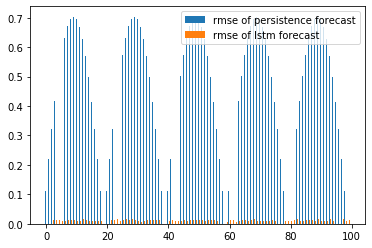

In [8]:
y_pers_test = np.transpose(np.tile(scaled_test[:,-num_predict-1], (num_predict,1)))

print(scaled_forecasts.shape,scaled_test.shape)

rmse_lstm_test = np.sqrt(np.mean((scaled_forecasts-scaled_test[:,-num_predict:])**2,axis=0))

rmse_pers_test = np.sqrt(np.mean((y_pers_test-scaled_test[:,-num_predict:])**2,axis=0))

plt.figure()
plt.bar(np.arange(0,num_predict)-0.2,rmse_pers_test,0.3,label='rmse of persistence forecast')
plt.bar(np.arange(0,num_predict)+0.2,rmse_lstm_test,0.3,label='rmse of lstm forecast')
plt.legend()

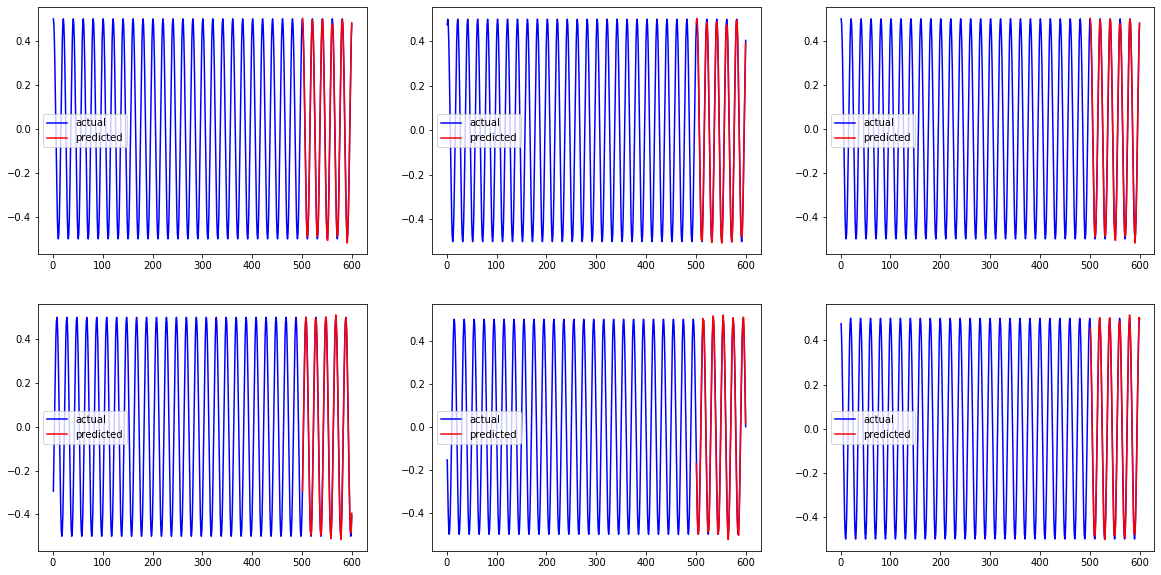

In [9]:
#look at a random sample to see how we did
%matplotlib inline
chunk_size = num_lookback + num_predict

plt.figure(figsize=(20,10))
for i in np.arange(1,7):
    sample = np.random.randint(0,scaled_forecasts.shape[0])
    plt.subplot(2,3,i)
    plt.plot(np.linspace(1,chunk_size,num=chunk_size),scl_sup_ds[sample+N_train,:],color='blue',label='actual')
    plt.plot(np.linspace(num_lookback+1,chunk_size,num=num_predict),scaled_forecasts[sample,:],color='red',label='predicted')
    plt.legend()

## 2) Noisy sin wave
The network did well with the sin wave, as it should. Let's add some noise to the sin wave and see how it does.

In [10]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dropout, LSTM, Dense, Activation
import time
import csv
from sklearn.metrics import mean_squared_error

np.random.seed(1234)

(0, 0.2)

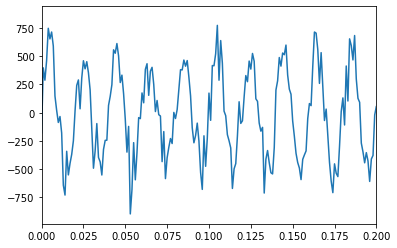

In [12]:
%matplotlib inline
df = pd.read_csv('./data/50Hzsinwave.csv',header=None)
dataset = df.values
dataset[:,1] = dataset[:,1]*500 # Put it in LFP scale

# Make noise vector with different levels of noise
noise = np.zeros((dataset.shape[0],5))
noise[:,0:1] = 50*np.random.randn(1,dataset.shape[0]).T
noise[:,1:2] = 100*np.random.randn(1,dataset.shape[0]).T
noise[:,2:3] = 150*np.random.randn(1,dataset.shape[0]).T
noise[:,3:4] = 200*np.random.randn(1,dataset.shape[0]).T
noise[:,4:5] = 250*np.random.randn(1,dataset.shape[0]).T

dataset[:,1] = dataset[:,1] + noise[:,2]


plt.plot(dataset[:,0],dataset[:,1])
plt.xlim(0,0.2)

In [13]:
from utils import series_to_supervised, fit_lstm, forecast_lstm, make_forecasts

# Series to supervised
num_lookback = 300
num_predict = 100

# n_in is the number of samples for "input" and n_out is the number for "output", or prediction
supervised_dataset = series_to_supervised(dataset[:,1:2],n_in=num_lookback,n_out=num_predict)
sup_ds = supervised_dataset.values

# Scale
row_mean = sup_ds.mean(axis=1,keepdims=True)
row_max = sup_ds.max(axis=1,keepdims=True)
row_min = sup_ds.min(axis=1,keepdims=True)

scl_sup_ds = (sup_ds-row_mean)/(row_max-row_min)

# Train test split
N_train = int(0.8*np.size(scl_sup_ds,0))

scaled_train = scl_sup_ds[0:N_train,:]
scaled_test = scl_sup_ds[N_train:,:]

# train    
model_lstm = fit_lstm(scaled_train, num_predict, 10, 20, 300)
model_lstm.summary()

# Make forecasts on test data
scaled_forecasts = make_forecasts(model_lstm, 1, scaled_test, num_predict)

# Make persistence forecasts
y_pers_test = np.transpose(np.tile(scaled_test[:,-num_predict-1], (num_predict,1)))

# Calculate root mean squared error on forecasts
rmse_lstm_test = np.sqrt(np.mean((scaled_forecasts-scaled_test[:,-num_predict:])**2,axis=0))

rmse_pers_test = np.sqrt(np.mean((y_pers_test-scaled_test[:,-num_predict:])**2,axis=0))

Epoch 1/20
480/480 [==============================] - 2s 4ms/step - loss: 0.0253
Epoch 2/20
480/480 [==============================] - 1s 2ms/step - loss: 0.0094
Epoch 3/20
480/480 [==============================] - 1s 2ms/step - loss: 0.0089
Epoch 4/20
480/480 [==============================] - 1s 2ms/step - loss: 0.0087
Epoch 5/20
480/480 [==============================] - 1s 2ms/step - loss: 0.0086
Epoch 6/20
480/480 [==============================] - 1s 2ms/step - loss: 0.0084
Epoch 7/20
480/480 [==============================] - 1s 2ms/step - loss: 0.0083
Epoch 8/20
480/480 [==============================] - 1s 2ms/step - loss: 0.0082
Epoch 9/20
480/480 [==============================] - 1s 2ms/step - loss: 0.0081
Epoch 10/20
480/480 [==============================] - 1s 2ms/step - loss: 0.0079
Epoch 11/20
480/480 [==============================] - 1s 2ms/step - loss: 0.0078
Epoch 12/20
480/480 [==============================] - 1s 3ms/step - loss: 0.0077
Epoch 13/20
480/480 [====

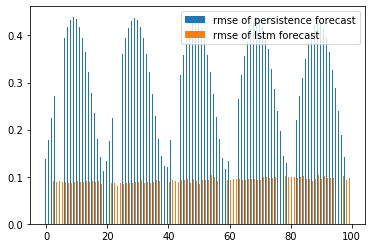

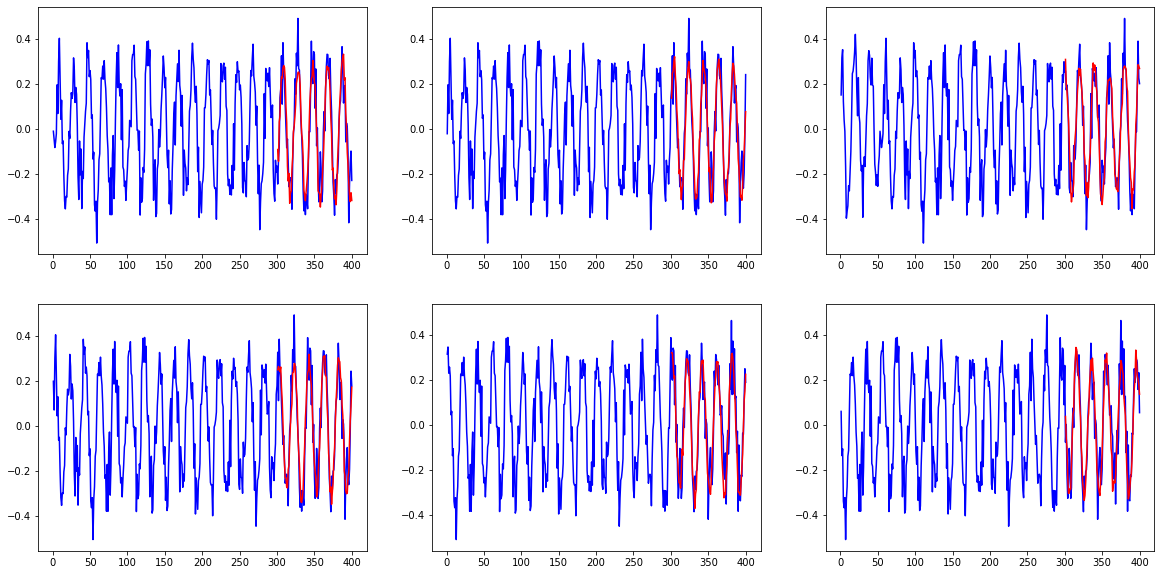

In [14]:
# Plot the persistence and LSTM forecasts
%matplotlib inline
plt.figure()
plt.bar(np.arange(0,num_predict)-0.2,rmse_pers_test,0.3,label='rmse of persistence forecast')
plt.bar(np.arange(0,num_predict)+0.2,rmse_lstm_test,0.3,label='rmse of lstm forecast')
plt.legend()

#look at 6 samples to see how we did
chunk_size = num_lookback + num_predict

plt.figure(figsize=(20,10))
for i in np.arange(1,7):
    sample = np.random.randint(0,scaled_forecasts.shape[0])
    plt.subplot(2,3,i)
    plt.plot(np.linspace(1,chunk_size,num=chunk_size),scl_sup_ds[sample+N_train,:],color='blue')
    plt.plot(np.linspace(num_lookback+1,chunk_size,num=num_predict),scaled_forecasts[sample,:],color='red')

## 3) Real LFP
The networks does well, even with a noisy sin wave. Now let's load some real LFP and see how it does.

In [4]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dropout, LSTM, Dense, Activation
import time
import csv
from sklearn.metrics import mean_squared_error
from scipy import signal

np.random.seed(1234)

(10, 100000.0)

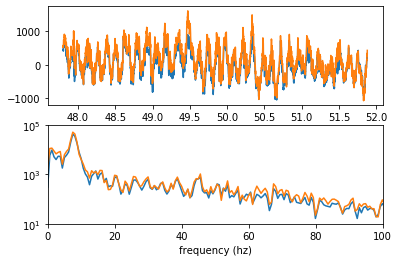

In [6]:
df = pd.read_csv('./data/HippTheta.csv',header=None)
dataset = df.values

fs = 1250

f, Pxx_den_mean = signal.welch(np.mean(dataset[:,1:],axis=1),fs,nperseg=2001)
f, Pxx_den = signal.welch(dataset[:,1],fs,nperseg=2001)

plt.subplot(2,1,1)
plt.plot(dataset[:,0],np.mean(dataset[:,1:],axis=1))
plt.plot(dataset[:,0],dataset[:,1])
plt.xlabel('time(ms)')
plt.subplot(2,1,2)
plt.semilogy(f,Pxx_den_mean)
plt.semilogy(f,Pxx_den)
plt.xlabel('frequency (hz)')
plt.xlim(0,100)
plt.ylim(10,10e4)

There is a clear peak in this signal at ~ 6 Hz, which is about what we would expect for hippocampal theta. However, there is also a lot of 1/f noise. Let's see how the network does!

Train on 3200 samples, validate on 801 samples
Epoch 1/5
3200/3200 [==============================] - 5s 2ms/step - loss: 0.0259 - val_loss: 0.0195
Epoch 2/5
3200/3200 [==============================] - 4s 1ms/step - loss: 0.0208 - val_loss: 0.0196
Epoch 3/5
3200/3200 [==============================] - 4s 1ms/step - loss: 0.0195 - val_loss: 0.0189
Epoch 4/5
3200/3200 [==============================] - 5s 1ms/step - loss: 0.0186 - val_loss: 0.0195
Epoch 5/5
3200/3200 [==============================] - 5s 1ms/step - loss: 0.0177 - val_loss: 0.0206
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 200)               200800    
_________________________________________________________________
dense_15 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_16 (Dense)             (

/home/mizzou/tools/utils/conda/envs/keras_tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:43: UserWarning: The handle 's' has a label of '_' which cannot be automatically added to the legend.
/home/mizzou/tools/utils/conda/envs/keras_tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:43: UserWarning: Legend does not support 'l' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/home/mizzou/tools/utils/conda/envs/keras_tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:43: UserWarning: Legend does not support 'o' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/home/mizzou/tools/utils/conda/envs/keras_tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:43: UserWarning: Legend does not support 's' instances

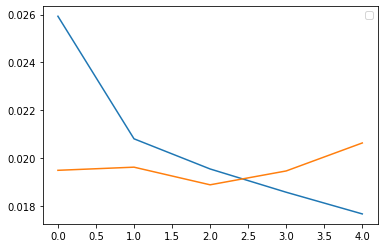

In [20]:
from utils import series_to_supervised, fit_lstm, forecast_lstm, make_forecasts

# Series to supervised
num_lookback = 50
num_predict = 50

# n_in is the number of samples for "input" and n_out is the number for "output", or prediction
supervised_dataset = series_to_supervised(dataset[:,1:2],n_in=num_lookback,n_out=num_predict)
sup_ds = supervised_dataset.values

# Scale
row_mean = sup_ds.mean(axis=1,keepdims=True)
row_max = sup_ds.max(axis=1,keepdims=True)
row_min = sup_ds.min(axis=1,keepdims=True)

scl_sup_ds = (sup_ds-row_mean)/(row_max-row_min)

# Train test split
N_train = int(0.8*np.size(scl_sup_ds,0))

scaled_train = scl_sup_ds[0:N_train,:]
scaled_test = scl_sup_ds[N_train:,:]

# train    
model_lstm, history_lstm = fit_lstm(scaled_train, num_predict, n_batch=10, nb_epoch=5, n_neurons=10)
model_lstm.summary()

# Make forecasts on test data
scaled_forecasts = make_forecasts(model_lstm, 1, scaled_test, num_predict)

# Make persistence forecasts
y_pers_test = np.transpose(np.tile(scaled_test[:,-num_predict-1], (num_predict,1)))

# Calculate root mean squared error on forecasts
rmse_lstm_test = np.sqrt(np.mean((scaled_forecasts-scaled_test[:,-num_predict:])**2,axis=0))
print("rmse for (LSTM) testing: ", rmse_lstm_test)

rmse_pers_test = np.sqrt(np.mean((y_pers_test-scaled_test[:,-num_predict:])**2,axis=0))
print("rmse for (persistence) testing: ", rmse_pers_test)

plt.plot(history_lstm.history['loss'])
plt.plot(history_lstm.history['val_loss'])
plt.legend('loss','val_loss')

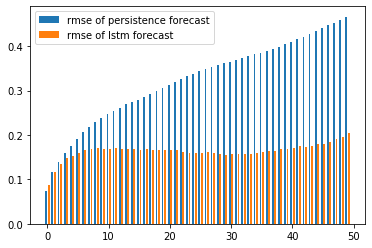

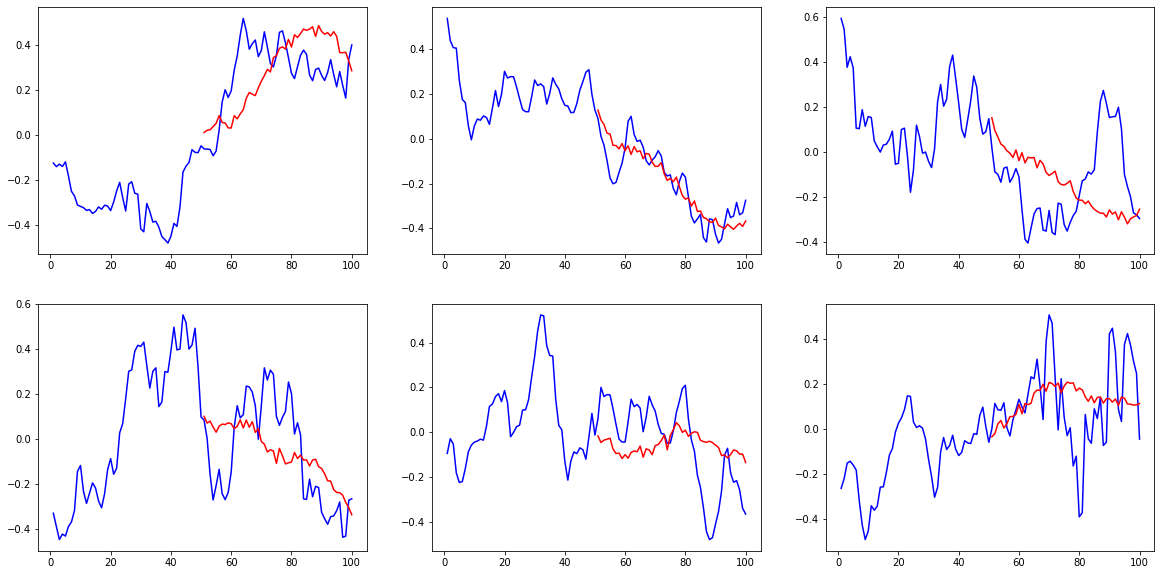

In [21]:
# Plot the persistence and LSTM forecasts
%matplotlib inline
plt.figure()
plt.bar(np.arange(0,num_predict)-0.2,rmse_pers_test,0.3,label='rmse of persistence forecast')
plt.bar(np.arange(0,num_predict)+0.2,rmse_lstm_test,0.3,label='rmse of lstm forecast')
plt.legend()

#look at 6 samples to see how we did
chunk_size = num_lookback + num_predict

plt.figure(figsize=(20,10))
for i in np.arange(1,7):
    sample = np.random.randint(0,scaled_forecasts.shape[0])
    plt.subplot(2,3,i)
    plt.plot(np.linspace(1,chunk_size,num=chunk_size),scl_sup_ds[sample+N_train,:],color='blue',label='actual')
    plt.plot(np.linspace(num_lookback+1,chunk_size,num=num_predict),scaled_forecasts[sample,:],color='red',label='predicted')